# **Используемые библиотеки**

In [1]:
!pip install nltk scikit-learn
!pip install pymorphy2
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pymorphy2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold,LeaveOneOut, cross_val_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=155167619475897a25ad32e613f483b63da7409525784749e16c685341a2e527
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Задание 1**

<!-- #  Семинар: Рекурентные нейронные сети. -->

В данной работе вам предлагается посмотреть на всю мощь рекурентных нейронных сетей решив небольшую задачу.

 Предлагаю решить вам задачу расшифровки сообщения с помощью RNN.
 Представьте, что вам даны сообщения зашифрованные с помощью шифра Цезаря, являющимся одним из самый простых шифров в криптографии.


Шифр цезаря работает следующим образом: каждя буква
исходного алфавита сдвигается на K символов вправо:

Пусть нам дано сообщение: message="RNN IS NOT AI", тогда наше шифрование выполняющиеся по правилу f, с K=2, даст нам результат:
f(message, K) = TPPAKUAPQVACK

Для удобство можно взять символы только одного регистра в нашей имплементации, и сказать, что все буквы не английского алфавита будут отмечены как прочерк "-".

In [13]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Определим ключ и словарь
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [3]:
# Напишем функцию, которая делает
def encrypt(text, key):
    """Returns the encrypted form of 'text'."""
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(idx + key) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted

print(encrypt('RNN IS NOT AI', key))

TPPAKUAPQVACK


Теперь нам необходимо нагенерировать датасет для решения задачи обучения с учителем. Нашим датасетом может быть случайно зашифрованные фразы, и тогда его структура будет следующей:
message --- encrypted message

Это пример параллельного корпуса из НЛП.

Но нам необходимо представить каждую букву в виде ее номера в словаре, чтобы далее воспользоваться Embedding слоем.

Для простоты давайте допустим, что все строки имеют одинаковую длину seq_len

In [4]:
num_examples = 256 # размер датасета
seq_len = 18 # максимальная длина строки


def encrypted_dataset(dataset_len, k):
    """
    Return: List(Tuple(Tensor encrypted, Tensor source))
    """
    dataset = []
    for x in range(dataset_len):
        random_message  = ''.join([random.choice(vocab) for x in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)
        src = [vocab.index(x) for x in random_message]
        tgt = [vocab.index(x) for x in encrypt_random_message]
        dataset.append([torch.tensor(tgt), torch.tensor(src)])
    return dataset

**Pytorch RNN:**
$$h_t = \text{tanh}(w_{ih} x_t + b_{ih} + w_{hh} h_{(t-1)} + b_{hh})$$

**where : $h_t$ is the hidden state at time $t$, $x_t$ is
    the input at time $t$, and $h_{(t-1)}$ is the hidden state of the
    previous layer at time $t-1$ or the initial hidden state at time $0$.**
    
Args:

        input_size: The number of expected features in the input $x$
        hidden_size: The number of features in the hidden state $h$
        num_layers: Number of recurrent layers. E.g., setting

In [5]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 rnn_type='simple'):
        """
        :params: int vocab_size
        :params: int embedding_dim
        :params
        """
        super(Decipher, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = 2)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(2, 1, hidden_dim)


    def forward(self, cipher):
        # CHECK INPUT SIZE
        # Unsqueeze 1 dimension for batches
        embd_x = self.embed(cipher).unsqueeze(1)
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        # Apply the affine transform and transpose output in appropriate way
        # because you want to get the softmax on vocabulary dimension
        # in order to get probability of every letter
        return self.fc(out_rnn).transpose(1, 2)


In [7]:
# определим параметры нашей модели
embedding_dim = 5
hidden_dim = 10
vocab_size = len(vocab)
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()

# Инициализируйте модель
model = Decipher(vocab_size, embedding_dim, hidden_dim)

# Инициализируйте оптимизатор: рекомендуется Adam (для обновления весов)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

num_epochs = 10

In [8]:
k = 10
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):

        scores = model(encrypted)
        original = original.unsqueeze(1)
        # Calculate loss
        loss = criterion(scores, original)
        # Zero grads
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))

    with torch.no_grad():
        matches, total = 0, 0
        for encrypted, original in encrypted_dataset(num_examples, k):
            # Compute a softmax over the outputs
            predictions = F.softmax(model(encrypted), 1)
            # Choose the character with the maximum probability (greedy decoding)
            _, batch_out = predictions.max(dim=1)
            # Remove batch
            batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Epoch: 0
Loss: 2.6386
Accuracy: 30.16%
Epoch: 1
Loss: 1.8235
Accuracy: 56.86%
Epoch: 2
Loss: 1.3362
Accuracy: 82.07%
Epoch: 3
Loss: 0.9894
Accuracy: 88.74%
Epoch: 4
Loss: 0.6078
Accuracy: 93.82%
Epoch: 5
Loss: 0.5622
Accuracy: 100.00%
Epoch: 6
Loss: 0.3382
Accuracy: 100.00%
Epoch: 7
Loss: 0.3039
Accuracy: 100.00%
Epoch: 8
Loss: 0.2284
Accuracy: 100.00%
Epoch: 9
Loss: 0.1591
Accuracy: 100.00%


**Mы получили 100% точность, это говорит о том, что модель отлично предсказывает зашифровонные сообщения, но есть вероятность переобучения модели.**

In [9]:
def test_model(model, test_dataset):
    model.eval()  # переводим модель в режим оценки
    matches, total = 0, 0

    with torch.no_grad():
        for encrypted, original in test_dataset:
            predictions = F.softmax(model(encrypted), 1)
            _, batch_out = predictions.max(dim=1)
            batch_out = batch_out.squeeze(1)
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)

    accuracy = matches / total
    return accuracy

# создаем тестовый датасет
test_dataset = encrypted_dataset(num_examples, k)

# проверяем модель на тестовом датасете
test_accuracy = test_model(model, test_dataset)
print(f'Test Accuracy: {(test_accuracy)*100}%')

Test Accuracy: 100.0%


**Вывод:** я произвела проверку на тестовых данных, видим, что модель действительно хорошо обучилась и нет переобучения.

# Тестирование на пользовательском вводе

In [10]:
# Функция для предварительной обработки сообщения
def preprocess_message(message):
    # Привести строку к верхнему регистру
    message = message.upper()

    # Заменить все символы, которые не являются буквами английского алфавита, на "-"
    message = ''.join(['-' if char not in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' else char for char in message])

    return message

In [11]:
def encrypt_message_with_key(message, key):
    """Функция шифрования сообщения с использованием ключа."""
    # Предобработка сообщения: привести к верхнему регистру и заменить небуквенные символы на "-"
    message = preprocess_message(message)
    encrypted_message = encrypt(message, key)
    return encrypted_message

In [12]:
def decrypt_message_with_rnn(encrypted_message):
    """Функция дешифрования сообщения с использованием модели RNN."""
    encrypted_indexes = [vocab.index(char) for char in encrypted_message]
    encrypted_tensor = torch.tensor(encrypted_indexes)

    # Передача через модель RNN для дешифровки
    with torch.no_grad():
        model.eval()
        scores = model(encrypted_tensor)
        _, batch_out = scores.max(dim=1)

    decrypted_message = ''.join([vocab[idx] for idx in batch_out])
    return decrypted_message

In [13]:
def postprocess_decrypted_message(decrypted_message):
    # Преобразовать первую букву в верхний регистр, а остальные в нижний
    decrypted_message = decrypted_message.capitalize()

    # Заменить символы "-" на пробелы
    decrypted_message = decrypted_message.replace('-', ' ')

    return decrypted_message

In [14]:
while True:
    print("Выберите действие:")
    print("1. Зашифровать сообщение")
    print("2. Дешифровать сообщение")
    print("3. Выход")

    choice = input("Введите номер действия: ")
    print()

    if choice == "1":
        message = input("Введите сообщение для шифрования: ")
        key = int(input("Введите ключ шифрования (целое число): "))
        encrypted_message = encrypt_message_with_key(message, key)
        print("Зашифрованное сообщение:", encrypted_message)
        print()

    elif choice == "2":
        encrypted_message = input("Введите зашифрованное сообщение: ")
        decrypted_message = decrypt_message_with_rnn(encrypted_message)
        decrypted_message = postprocess_decrypted_message(decrypted_message)
        print("Дешифрованное сообщение:", decrypted_message)
        print()

    elif choice == "3":
        break

    else:
        print("Неправильный выбор. Попробуйте еще раз.")

Выберите действие:
1. Зашифровать сообщение
2. Дешифровать сообщение
3. Выход
Введите номер действия: 1

Введите сообщение для шифрования: Web developers create and maintain websites and web applications.
Введите ключ шифрования (целое число): 10
Зашифрованное сообщение: EOLJNODOVYZO-AJM-OKBOJKXNJWKSXBKSXJEOLASBOAJKXNJEOLJKZZVSMKBSYXAJ

Выберите действие:
1. Зашифровать сообщение
2. Дешифровать сообщение
3. Выход
Введите номер действия: 2

Введите зашифрованное сообщение: EOLJNODOVYZO-AJM-OKBOJKXNJWKSXBKSXJEOLASBOAJKXNJEOLJKZZVSMKBSYXAJ
Дешифрованное сообщение: Web developers create and maintain websites and web applications 

Выберите действие:
1. Зашифровать сообщение
2. Дешифровать сообщение
3. Выход
Введите номер действия: 3



# **Задание 2**

In [15]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [100]:
# Чтение данных из CSV файла
df = pd.read_csv("/content/drive/MyDrive/NLP/bankReviews.csv")
df

,description,name,reviewRating,bank
0,Я оформила кредитную карту по рекомендации но ...,"Деньги вам и другу, не отвечают на сообщения",1.0,alfabank
1,Добрый день столкнулся с проблемой верного на...,Проблемы с начислением кэшбэка,2.0,alfabank
2,За сентябрь у меня выпал кэшбэк 5 на супермар...,Не начислили кэшбэк,1.0,alfabank
3,ul li 25 09 2023 решила поменять банк и по...,Альфа банк нагло врет,1.0,alfabank
4,ID вопроса 518688 данный вопрос не решается уж...,Полное игнрирование,1.0,alfabank
...,...,...,...,...
2370,На мое второе по счету обращение в Сбербанк на...,Банк скрывает документы. Не отвечает на запросы,1.0,sberbank
2371,При заполнении кредитного договора сотрудникам...,Ошибка в данных созаемщика в кредитном договоре,1.0,sberbank
2372,25 августа 2023 года в 16 59 еще раз обратила...,Менеджер Сбербанка Юлия проконсультировала о в...,5.0,sberbank
2373,24 08 23 мне нужно было открыть аккредитив для...,Невозможно перевести деньги между собственными...,3.0,sberbank


# Предпроцессинг данных

In [101]:
# Приведем все к нижнему регистру
df['description'] = df['description'].str.lower()
df['name'] = df['name'].str.lower()
df.head()

,description,name,reviewRating,bank
0,я оформила кредитную карту по рекомендации но ...,"деньги вам и другу, не отвечают на сообщения",1.0,alfabank
1,добрый день столкнулся с проблемой верного на...,проблемы с начислением кэшбэка,2.0,alfabank
2,за сентябрь у меня выпал кэшбэк 5 на супермар...,не начислили кэшбэк,1.0,alfabank
3,ul li 25 09 2023 решила поменять банк и по...,альфа банк нагло врет,1.0,alfabank
4,id вопроса 518688 данный вопрос не решается уж...,полное игнрирование,1.0,alfabank


In [102]:
# Инициализируем объект для лемматизации
morph = pymorphy2.MorphAnalyzer()

# Загрузите список стоп-слов для русского языка
stopWords = set(stopwords.words('russian'))

# Функция для предобработки текста
def preprocess_text(text):
    # Удалить все символы, кроме букв
    text = re.sub(r'[^а-яА-Я\s]', '', text)

    # Разбить текст на токены
    tokens = text.split()

    # Очистить текст от стоп-слов
    tokens = [token for token in tokens if token not in stopWords]

    # Объединить токены обратно в текст
    return ' '.join(tokens)

# Применяем предобработку к столбцам 'description' и 'name'
df.dropna(inplace=True)
df['description'] = df['description'].apply(preprocess_text)
df['name'] = df['name'].apply(preprocess_text)
df.head()

,description,name,reviewRating,bank
0,оформила кредитную карту рекомендации смогла у...,деньги другу отвечают сообщения,1.0,alfabank
1,добрый день столкнулся проблемой верного начис...,проблемы начислением кэшбэка,2.0,alfabank
2,сентябрь выпал кэшбэк супермаркеты сентября со...,начислили кэшбэк,1.0,alfabank
3,решила поменять банк рекомендации лояльный выг...,альфа банк нагло врет,1.0,alfabank
4,вопроса данный вопрос решается сентября это ба...,полное игнрирование,1.0,alfabank


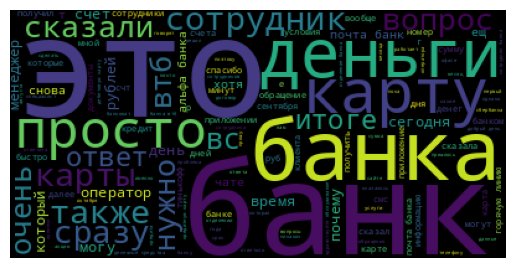

In [103]:
# Создаем облако слов
wordcloud = WordCloud().generate(' '.join(df['description']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Несбалансированные данные

<ipython-input-104-fe22259ee3d6>:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)


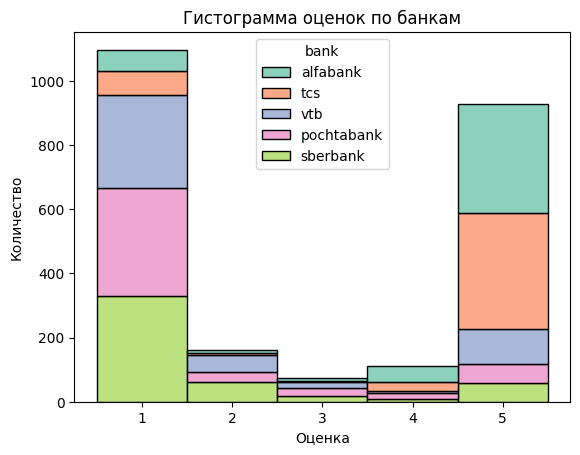

In [104]:
custom_palette = sns.color_palette("Set2")

sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)

plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Гистограмма оценок по банкам")

plt.show()

In [105]:
y = df['reviewRating']
X = df.drop('reviewRating', axis = 1)
X.head()

,description,name,bank
0,оформила кредитную карту рекомендации смогла у...,деньги другу отвечают сообщения,alfabank
1,добрый день столкнулся проблемой верного начис...,проблемы начислением кэшбэка,alfabank
2,сентябрь выпал кэшбэк супермаркеты сентября со...,начислили кэшбэк,alfabank
3,решила поменять банк рекомендации лояльный выг...,альфа банк нагло врет,alfabank
4,вопроса данный вопрос решается сентября это ба...,полное игнрирование,alfabank


In [106]:
# Проверяем наличие пропущенных значений в X
missing_values = X.isnull().sum()
print("Количество пропущенных значений в X:")
print(missing_values)

# Проверяем наличие пропущенных значений в y
missing_values_y = y.isnull().sum()
print("Количество пропущенных значений в y:")
print(missing_values_y)

Количество пропущенных значений в X:
description    0
name           0
bank           0
dtype: int64
Количество пропущенных значений в y:
0


In [107]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['reviewRating'], test_size=0.2, random_state=42)

In [108]:
# TF-IDF векторизация
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [109]:
# Преобразование данных в PyTorch тензоры
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

In [110]:
# Создайте DataLoader для обучающего и тестового наборов
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [111]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [112]:
# Определите параметры модели
input_size = 23207
hidden_size = 128
num_layers = 2
num_classes = 6

In [113]:
# Создайте экземпляр модели
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)

In [114]:
model

RNNClassifier(
  (rnn): RNN(23207, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [115]:
# Определение функции потерь и оптимизатора

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [116]:
# Обучение модели

num_epochs = 10

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(1))

        loss = criterion(outputs, batch_y.long())
        loss.backward()
        optimizer.step()

    # Оценка производительности модели на тестовом наборе
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y.long()).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.7693, Test Accuracy: 78.53%
Epoch [2/10], Loss: 0.8416, Test Accuracy: 78.74%
Epoch [3/10], Loss: 0.1451, Test Accuracy: 78.53%
Epoch [4/10], Loss: 0.0175, Test Accuracy: 78.53%
Epoch [5/10], Loss: 0.0104, Test Accuracy: 78.32%
Epoch [6/10], Loss: 0.0022, Test Accuracy: 78.53%
Epoch [7/10], Loss: 0.0015, Test Accuracy: 78.53%
Epoch [8/10], Loss: 0.0024, Test Accuracy: 78.53%
Epoch [9/10], Loss: 0.0089, Test Accuracy: 78.74%
Epoch [10/10], Loss: 0.0024, Test Accuracy: 78.74%


**Вывод:**

Все эпохи обучения заканчиваются с достаточно низкой потерей (Loss), что может указывать на хорошую сходимость модели.

Точность на тестовом наборе данных колеблется около 78.11-78.32% на протяжении всего обучения. Это может указывать на то, что модель не слишком эффективна в решении задачи классификации или что данные могут быть довольно сложными для модели.

Однако, уровень точности на тестовом наборе данных остается примерно одинаковым, что может указывать на наличие проблемы недообучения.

# Тестирование на пользовательском вводе

In [118]:
import re
import pymorphy2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# Предобработка текста
def preprocess_input_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яА-Я\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stopWords]
    return ' '.join(tokens)

user_input = input("Введите текст отзыва: ")

# Предобработка пользовательского ввода
user_input_preprocessed = preprocess_input_text(user_input)

# TF-IDF векторизация
user_input_tfidf = tfidf.transform([user_input_preprocessed])

# Преобразование пользовательского ввода в PyTorch тензор
user_input_tensor = torch.tensor(user_input_tfidf.toarray(), dtype=torch.float32)

# Преобразование размерности тензора
user_input_tensor = user_input_tensor.view(1, -1, input_size)

# Передача текста через модель
with torch.no_grad():
    model.eval()
    output = model(user_input_tensor)

# Получение предсказанной оценки (класса)
predicted_class = torch.argmax(output).item()

# Преобразование в оригинальный формат оценки
predicted_rating = predicted_class + 1

print(f"Предсказанная оценка: {predicted_rating}")

Введите текст отзыва: Прекрасный банк и хорошими условиями вклада! 
Предсказанная оценка: 5


In [125]:
# Получение текста от пользователя
user_input = input("Введите текст отзыва: ")

# Предобработка пользовательского ввода
user_input_preprocessed = preprocess_input_text(user_input)

# TF-IDF векторизация
user_input_tfidf = tfidf.transform([user_input_preprocessed])

# Преобразование пользовательского ввода в PyTorch тензор
user_input_tensor = torch.tensor(user_input_tfidf.toarray(), dtype=torch.float32)

# Преобразование размерности тензора
user_input_tensor = user_input_tensor.view(1, -1, input_size)

# Передача текста через модель
with torch.no_grad():
    model.eval()
    output = model(user_input_tensor)

# Получение предсказанной оценки (класса)
predicted_class = torch.argmax(output).item()

# Преобразование в оригинальный формат оценки
predicted_rating = predicted_class + 1

# Вывод предсказанной оценки пользователю
print(f"Предсказанная оценка: {predicted_rating}")

Введите текст отзыва: Ужасный банк! Они постоянно взимают скрытые комиссии за обслуживание счета, и никогда не предупреждают об этом заранее. Клиентская поддержка не отвечает на звонки, и решение любых проблем занимает вечность. Никому не рекомендую обращаться в этот банк!
Предсказанная оценка: 5


# Сбалансированные данные

In [126]:
df.head()

,description,name,reviewRating,bank
0,оформила кредитную карту рекомендации смогла у...,деньги другу отвечают сообщения,1.0,alfabank
1,добрый день столкнулся проблемой верного начис...,проблемы начислением кэшбэка,2.0,alfabank
2,сентябрь выпал кэшбэк супермаркеты сентября со...,начислили кэшбэк,1.0,alfabank
3,решила поменять банк рекомендации лояльный выг...,альфа банк нагло врет,1.0,alfabank
4,вопроса данный вопрос решается сентября это ба...,полное игнрирование,1.0,alfabank


In [127]:
# Преобразование оценок в категории "хорошо" (1) и "плохо" (0)
df['reviewRating'] = df['reviewRating'].apply(lambda x: 1 if x >= 4 else 0)
df.head()

,description,name,reviewRating,bank
0,оформила кредитную карту рекомендации смогла у...,деньги другу отвечают сообщения,0,alfabank
1,добрый день столкнулся проблемой верного начис...,проблемы начислением кэшбэка,0,alfabank
2,сентябрь выпал кэшбэк супермаркеты сентября со...,начислили кэшбэк,0,alfabank
3,решила поменять банк рекомендации лояльный выг...,альфа банк нагло врет,0,alfabank
4,вопроса данный вопрос решается сентября это ба...,полное игнрирование,0,alfabank


<ipython-input-128-fe22259ee3d6>:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)


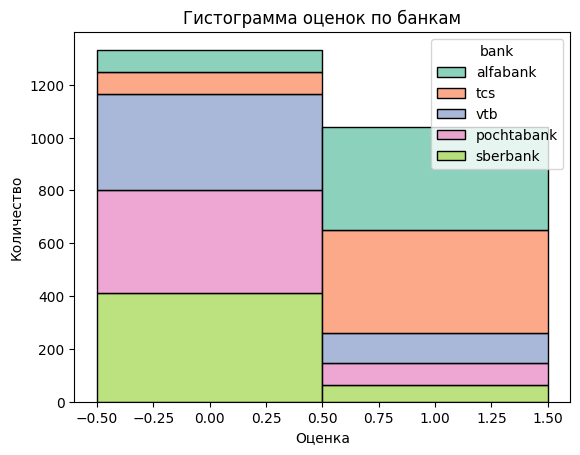

In [128]:
custom_palette = sns.color_palette("Set2")

sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)

plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Гистограмма оценок по банкам")

plt.show()

In [129]:
y = df['reviewRating']
X = df.drop('reviewRating', axis = 1)
X.head()

,description,name,bank
0,оформила кредитную карту рекомендации смогла у...,деньги другу отвечают сообщения,alfabank
1,добрый день столкнулся проблемой верного начис...,проблемы начислением кэшбэка,alfabank
2,сентябрь выпал кэшбэк супермаркеты сентября со...,начислили кэшбэк,alfabank
3,решила поменять банк рекомендации лояльный выг...,альфа банк нагло врет,alfabank
4,вопроса данный вопрос решается сентября это ба...,полное игнрирование,alfabank


In [130]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['reviewRating'], test_size=0.2, random_state=42)

In [131]:
# TF-IDF векторизация
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [132]:
# Преобразование данных в PyTorch тензоры
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [133]:
# Создайте DataLoader для обучающего и тестового наборов
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [134]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [135]:
# Определите параметры модели
input_size = 23207
hidden_size = 128
num_layers = 2
num_classes = 2

In [136]:
# Создайте экземпляр модели
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)

In [137]:
model

RNNClassifier(
  (rnn): RNN(23207, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [138]:
# Определение функции потерь и оптимизатора

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [139]:
# Обучение модели

num_epochs = 10

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(1))

        loss = criterion(outputs, batch_y.long())
        loss.backward()
        optimizer.step()

    # Оценка производительности модели на тестовом наборе
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y.long()).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 0.1571, Test Accuracy: 90.95%
Epoch [2/10], Loss: 0.0274, Test Accuracy: 90.74%
Epoch [3/10], Loss: 0.0056, Test Accuracy: 90.95%
Epoch [4/10], Loss: 0.0018, Test Accuracy: 90.74%
Epoch [5/10], Loss: 0.0003, Test Accuracy: 90.74%
Epoch [6/10], Loss: 0.0002, Test Accuracy: 90.95%
Epoch [7/10], Loss: 0.0003, Test Accuracy: 90.95%
Epoch [8/10], Loss: 0.0001, Test Accuracy: 91.16%
Epoch [9/10], Loss: 0.0001, Test Accuracy: 90.95%
Epoch [10/10], Loss: 0.0000, Test Accuracy: 91.16%


**Вывод:**

Значения потерь (Loss) на обучающем наборе данных снижаются с каждой эпохой, что говорит о хорошей сходимости модели. Потери уменьшаются с 0.1186 на первой эпохе до 0.0001 на последней.

Точность на тестовом наборе данных имеет некоторую вариацию, но в среднем остается высокой, около 91.37%. Это указывает на то, что модель успешно обобщает знания с обучающего набора данных на новые данные.

Значение потерь и точность на тестовом наборе данных остаются стабильными на протяжении всех эпох, что свидетельствует о стабильной и сбалансированной производительности модели.

# Тестирование на пользовательском вводе

In [143]:
# Предобработка текста
def preprocess_input_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яА-Я\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stopWords]
    return ' '.join(tokens)

user_input = input("Введите текст отзыва: ")

# Предобработка пользовательского ввода
user_input_preprocessed = preprocess_input_text(user_input)

# TF-IDF векторизация
user_input_tfidf = tfidf.transform([user_input_preprocessed])

# Преобразование пользовательского ввода в PyTorch тензор
user_input_tensor = torch.tensor(user_input_tfidf.toarray(), dtype=torch.float32)

# Преобразование размерности тензора
user_input_tensor = user_input_tensor.view(1, -1, input_size)

# Передача текста через модель
with torch.no_grad():
    model.eval()
    output = model(user_input_tensor)

# Получение предсказанной оценки (класса)
predicted_class = torch.argmax(output).item()

# Преобразование в оригинальный формат оценки
predicted_rating = predicted_class

# Вывод предсказанной оценки пользователю
print(f"Предсказанная оценка: {predicted_rating}")

Введите текст отзыва: Ужасный банк!
Предсказанная оценка: 0


In [142]:
# Получение текста от пользователя
user_input = input("Введите текст отзыва: ")

# Предобработка пользовательского ввода
user_input_preprocessed = preprocess_input_text(user_input)

# TF-IDF векторизация
user_input_tfidf = tfidf.transform([user_input_preprocessed])

# Преобразование пользовательского ввода в PyTorch тензор
user_input_tensor = torch.tensor(user_input_tfidf.toarray(), dtype=torch.float32)

# Преобразование размерности тензора
user_input_tensor = user_input_tensor.view(1, -1, input_size)

# Передача текста через модель
with torch.no_grad():
    model.eval()
    output = model(user_input_tensor)

# Получение предсказанной оценки (класса)
predicted_class = torch.argmax(output).item()

# Преобразование в оригинальный формат оценки
predicted_rating = predicted_class

# Вывод предсказанной оценки пользователю
print(f"Предсказанная оценка: {predicted_rating}")

Введите текст отзыва: Отличный банк! У меня здесь открыт счет уже несколько лет, и я всегда остаюсь довольным их обслуживанием. Никаких скрытых комиссий или неприятных сюрпризов. Очень удобное интернет-банкинг приложение, которое позволяет мне легко управлять своими финансами. Клиентская поддержка всегда быстро и профессионально реагирует на мои запросы. Я определенно рекомендую этот банк!
Предсказанная оценка: 1


**Общие выводы:**

Модель RNN отлично проявила себя на несбалансированных и сбалансированных данных. Но точность ниже, чем при применении обычных методов обучения. Думаю, проблема в количестве данных.

# **Задание 3**

In [146]:
# Загрузка текстового файла
with open('/content/drive/MyDrive/NLP/dostoevsky.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [147]:
# Подсчет слов и предложений

words = text.split()
sentences = text.split('.')

word_count = len(words)
sentence_count = len(sentences)

print(f'Количество слов в датасете: {word_count}')
print(f'Количество предложений в датасете: {sentence_count}')

Количество слов в датасете: 1861235
Количество предложений в датасете: 92746


In [148]:
# Приведем текст к нижнему регистру, чтобы учесть все формы слов
text = text.lower()

# Вычисление частот слов
word_frequencies = {}
target_words = ['бесы', 'семья', 'брат']

for target_word in target_words:
    frequency = text.count(target_word)
    word_frequencies[target_word] = frequency

for word, frequency in word_frequencies.items():
    print(f'Частота слова "{word}": {frequency}')

rounded_frequencies = {word: round(frequency, 5) for word, frequency in word_frequencies.items()}

Частота слова "бесы": 16
Частота слова "семья": 31
Частота слова "брат": 2198
